In [1]:
import pandas as pd
from datasets import Dataset
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer,
                          DataCollatorWithPadding)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import stopwords as nltk_stopwords

# Загрузка размеченного датасета

In [2]:
# 1. Загружаем данные
df = pd.read_csv('geo-reviews-dataset-2023.csv') # Колонки: 'review', 'label'
df_1 = df.loc[df['label'] == 1]
df_2 = df.loc[df['label'] == 2]
df_3 = df.loc[df['label'] == 3]
df_4 = df.loc[df['label'] == 4]
df_5 = df.loc[df['label'] == 5]

df_new = pd.concat([df_1[0:2000], df_2[0:2000], df_3[0:2000], df_4[0:2000], df_5[0:2000]], ignore_index=True)
df_new = df_new.sample(frac=1).reset_index(drop=True) #перемешать
df_new.shape

(10000, 2)

In [3]:
df_new.head()

,review,label
0,Хороший магазин.Много разного товара.Но и цены...,5
1,Всегда всё очень вкусно! Заказываем только мир...,5
2,"Магазин не плохой, много хорошей одежды. Но во...",2
3,Много лет мужем покупали и делали очки в этой ...,3
4,"Очень неплохое заведение. Свежая выпечка, начи...",4


In [4]:
test_df = pd.concat([df_1[2000:2200], df_2[2000:2200], df_3[2000:2200], df_4[2000:2200], df_5[2000:2200]], ignore_index=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Предобработка отзывов

In [5]:
# Оставим в тексте только кириллические символы
def clear_text(text):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return " ".join(clear_text.split())

# напишем функцию удаляющую стоп-слова
def clean_stop_words(text, stopwords):
    text = [word for word in text.split() if word not in stopwords]
    return " ".join(text)

# загрузим список стоп-слов
stopwords = set(nltk_stopwords.words('russian'))
np.array(stopwords)

array({'можно', 'тебя', 'том', 'без', 'есть', 'вот', 'свою', 'эту', 'за', 'все', 'какая', 'ее', 'мне', 'опять', 'ней', 'тогда', 'чем', 'другой', 'им', 'через', 'ни', 'ли', 'ему', 'два', 'них', 'того', 'тоже', 'потому', 'всегда', 'об', 'моя', 'но', 'какой', 'совсем', 'когда', 'будто', 'иногда', 'в', 'всех', 'себя', 'ты', 'нас', 'больше', 'лучше', 'перед', 'чего', 'были', 'будет', 'хорошо', 'а', 'чуть', 'при', 'чтобы', 'по', 'этот', 'вас', 'над', 'то', 'не', 'теперь', 'к', 'кто', 'такой', 'под', 'почти', 'со', 'разве', 'ведь', 'уж', 'зачем', 'нет', 'между', 'быть', 'сейчас', 'во', 'было', 'раз', 'же', 'куда', 'до', 'тем', 'о', 'от', 'мой', 'сам', 'у', 'этого', 'нибудь', 'ей', 'тут', 'него', 'ж', 'этом', 'так', 'да', 'ну', 'надо', 'тот', 'еще', 'ним', 'с', 'где', 'эти', 'этой', 'чтоб', 'может', 'вам', 'нельзя', 'после', 'или', 'был', 'нее', 'ничего', 'хоть', 'и', 'он', 'вдруг', 'уже', 'один', 'была', 'она', 'мы', 'никогда', 'впрочем', 'как', 'много', 'я', 'всю', 'три', 'из', 'здесь', 'про

In [6]:
import re
# Протестируем работу функции очистки текста
review = df_new['review'][np.random.randint(df_new.shape[0])]
print(review)
print('=======================================')
print(clean_stop_words((clear_text(review)), stopwords))

В принципе для детей хорошее время припровождения, играть детям всегда весело. Но контроль безопасности детей отсутствует, в кафе цены выше, чем в Астории. Очередное место зарабатывания на детях.
принципе детей хорошее время припровождения играть детям весело контроль безопасности детей отсутствует кафе цены выше астории очередное место зарабатывания детях


In [7]:
import time
# Очистим тексты отзывов
start_clean = time.time()

df_new['review'] = df_new['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

print('Обработка текстов заняла: '+str(round(time.time() - start_clean, 2))+' секунд')

Обработка текстов заняла: 0.31 секунд


In [8]:
dataset = Dataset.from_pandas(df_new)

# 2. Загружаем токенизатор
model_name = 'sberbank-ai/ruBert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3. Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples['review'], truncation=True, padding=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 4. Разделяем на train/test
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)

# 5. Загружаем модель с нужным количеством классов
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# 6. Определяем метрики для оценки
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

In [12]:
# 7. Настраиваем гиперпараметры обучения
training_args = TrainingArguments(
    output_dir='./results_m2',          # Куда сохранять результаты
    eval_strategy="epoch",     # Оценивать после каждой эпохи
    learning_rate=5e-05,              # Скорость обучения (была 2e-5)
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    seed=42,
    lr_scheduler_type='cosine',
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='./logs',
)

In [13]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [14]:
# 8. Создаем Data Collator для динамического дополнения последовательностей
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 9. Создаем Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 10. Запускаем обучение!
trainer.train()

# 11. Сохраняем модель
trainer.save_model('./my_sentiment_model_2')

C:\Users\andre\AppData\Local\Temp\ipykernel_3936\899701250.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.149700,1.084636,0.514000,0.490058
2,0.857700,1.171759,0.540000,0.543321
3,0.547500,1.600340,0.548000,0.549159


In [15]:
import torch

In [16]:
model = AutoModelForSequenceClassification.from_pretrained('./my_sentiment_model_2')
tokenizer = AutoTokenizer.from_pretrained('./my_sentiment_model_2')
# Функция для предсказания настроения
def predict_sentiment(text):
    # Токенизируем текст и подготавливаем для модели
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    # Подаем на вход модели без вычисления градиентов (только инференс)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Получаем предсказания
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    # Названия классов, которые возвращает модель (уточните в документации к модели)
    classes = ['НЕГАТИВНЫЙ', 'ПОЗИТИВНЫЙ'] 
    
    # Находим индекс класса с максимальной вероятностью
    predicted_class_idx = predicted.argmax().item()
    sentiment = predicted_class_idx #classes[predicted_class_idx]
    confidence = predicted[0][predicted_class_idx].item()
    
    return sentiment, confidence

In [17]:
# Пример
# Очистим тексты отзывов
test_df['review'] = test_df['review']\
     .apply(lambda x: clean_stop_words(clear_text(str(x)), stopwords))

In [18]:
# 1 минута на 1000 отзывов
test_df['prediction'] = test_df['review']\
        .apply(lambda x: predict_sentiment(str(x))[0])
test_df.head()

,review,label,prediction
0,хороший отель номера чистые убирают каждый ден...,4,5
1,будучи немного причастен барной индустрии дово...,2,2
2,хороший магазин центре города широкий ассортим...,4,4
3,очень красиво чисто хорошая еда мангале единст...,4,3
4,качество мойки живая очередь рекламных плаката...,4,3


In [20]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_df['label'], test_df['prediction'])
print(matrix)

[[121  62  14   2   1]
 [ 51  90  44  14   1]
 [ 13  54  79  52   2]
 [  1  12  57 101  29]
 [  2   2   8  55 133]]


In [21]:
test_df['spread_distance'] = ((test_df['label'] - test_df['prediction']) ** 2)
test_df.head()

,review,label,prediction,spread_distance
0,хороший отель номера чистые убирают каждый ден...,4,5,1
1,будучи немного причастен барной индустрии дово...,2,2,0
2,хороший магазин центре города широкий ассортим...,4,4,0
3,очень красиво чисто хорошая еда мангале единст...,4,3,1
4,качество мойки живая очередь рекламных плаката...,4,3,1


In [22]:
dups = test_df.pivot_table(index = ['spread_distance'], aggfunc ='size')
print(dups)

spread_distance
0     524
1     404
4      63
9       6
16      3
dtype: int64


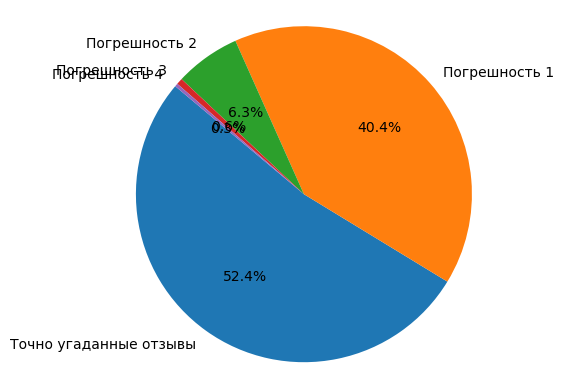

In [23]:
from matplotlib import pyplot as plt

sizes = [dups[0], dups[1], dups[4], dups[9], dups[16]]
labels = ['Точно угаданные отзывы', 'Погрешность 1', 'Погрешность 2', 'Погрешность 3', 'Погрешность 4']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140) 
plt.axis('equal')
plt.show() 